## Introduction

In this project we are interested in building a model that predicts the types of animals and the number of animals shown on images in the *Wild* dataset.  We will deviate from the approach used by [Parham et al.](https://ieeexplore.ieee.org/document/8354227) and employ a less complicated method inspired by the one used in [*Learn to Classify and Count: A Unified Framework for Object Classification and Counting*](https://dl.acm.org/doi/abs/10.1145/3191442.3191459) by Song and Qui instead.

The unique names of the animals of interest are stored in the list `reduced_classes` below. For each image, our goal is to identify the animals shown on the image and count how many there are.

In [1]:
import os
import numpy as np
import pandas as pd

import torch
import torch.nn as nn

import cv2 # an image and video processing library
from PIL import Image # Python Imaging Library

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
reduced_classes = ['giraffe_reticulated','zebra_grevys','turtle_sea',
                   'zebra_plains','giraffe_masai', 'whale_fluke']


In Precept 10 we have created two collections of files to store the NumPy arrays:

* `classify_arr`: with 0 and 1 elements classifying if an animal in `reduced_classes` shows up on the image  
* `count_arr`: with integers counting how many animals showing up on the image for each animal in `reduced_classes`

## Data Quality Check & EDA



There should be 5784 files in both the counts folder and classification folder.

In [3]:
count_file_names = os.listdir('wild/count_annotations')
class_file_names = os.listdir('wild/class_annotations')
print(len(count_file_names))
print(len(class_file_names))

5784
5784


Quick check that class and count annotations are correct.

In [4]:
# names of files to be inspected
file_names_subset = ['2018_002805.npy', '2018_000974.npy', '2018_000960.npy', '2018_002811.npy', '2018_004290.npy',
                     '2018_002839.npy', '2018_003299.npy', '2018_002187.npy', '2018_000948.npy', '2018_000790.npy',
                     '2018_001483.npy', '2018_000789.npy', '2018_000951.npy', '2018_001497.npy', '2018_003280.npy']

In [5]:
for file in file_names_subset:
    print(np.load('wild/class_annotations/' + file))

[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]


Outputs for `classify_arr` should match the following:

```python
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]
```

In [6]:
for file in file_names_subset:
    print(np.load('wild/count_annotations/' + file))

[4. 0. 0. 0. 0. 0.]
[0. 0. 0. 3. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 2. 0.]
[0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 2. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 2. 0. 0.]
[0. 0. 0. 0. 1. 0.]


Outputs for `count_arr` should match the following:

```python
[4. 0. 0. 0. 0. 0.]
[0. 0. 0. 3. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1.]
[1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 2. 0.]
[0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 2. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 0. 1. 0.]
[0. 0. 0. 2. 0. 0.]
[0. 0. 0. 0. 1. 0.]
```

## Basic Count Statistics

In [7]:
# getting number of animals in each observation
num_obs = 5784
num_animals = [0] * num_obs
for idx, file in enumerate(count_file_names):
  num_animals[idx] = np.load('wild/count_annotations/' + file).sum()

In [8]:
print('Maximum animals per image: ' + str(np.max(num_animals)))
print('Minimum animals per image: ' + str(np.min(num_animals)))

Maximum animals per image: 22.0
Minimum animals per image: 1.0


So, there is always *some* animal in any given image.

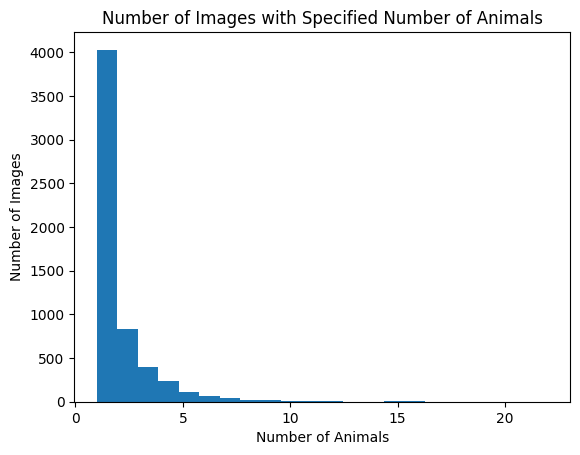

In [9]:
plt.hist(num_animals, bins=22) # min=1 & max=22, so bins=22 shows all
plt.title('Number of Images with Specified Number of Animals')
plt.xlabel('Number of Animals')
plt.ylabel('Number of Images')
plt.show()

The histogram has a long right tail. In fact, about 4000 of the 5784 images show just one animal. There are very rarely more than 7 animals per image, even though there are up to 22 animals per image.

In [10]:
num_animals = np.zeros((num_obs, 6))
for idx, file in enumerate(count_file_names):
  num_animals[idx,:] = np.load('wild/count_annotations/' + file)

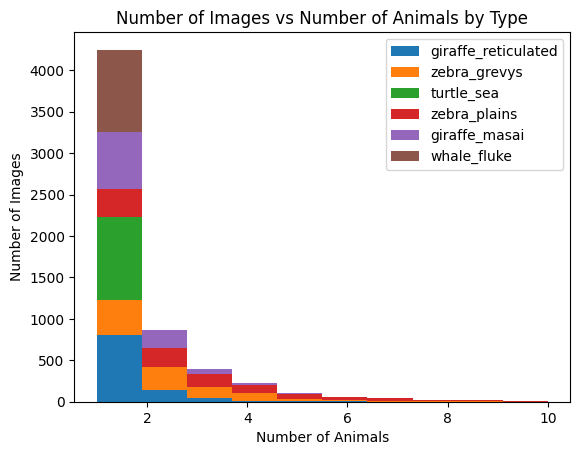

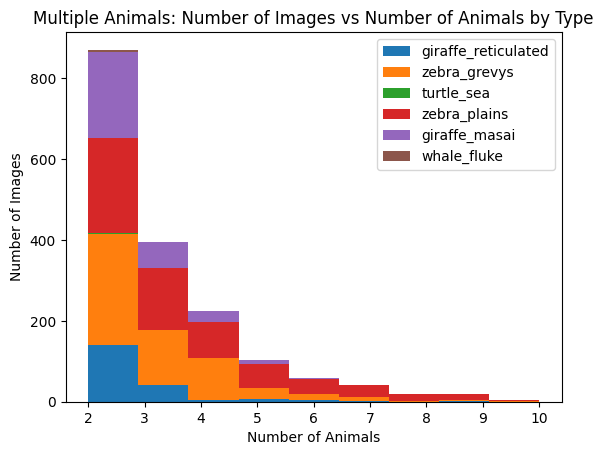

In [11]:
plt.hist(num_animals, bins=10, range=(1,10), stacked=True)
plt.legend(reduced_classes)
plt.title('Number of Images vs Number of Animals by Type')
plt.xlabel('Number of Animals')
plt.ylabel('Number of Images')
plt.show()

plt.hist(num_animals, bins=9, range=(2,10), stacked=True)
plt.legend(reduced_classes)
plt.title('Multiple Animals: Number of Images vs Number of Animals by Type')
plt.xlabel('Number of Animals')
plt.ylabel('Number of Images')
plt.show()

Fluke whales and sea turtles are almost always seen alone. In the second histogram, we see that reticulated giraffes rarely exceed groups of 3, and masai giraffes rarely exceed groups of 4-5. Likewise, we see both types of zebra appearing in groups of up to 7-9 with plains zebras slightly favoring bigger groups than the grevys zebras. Like previously mentioned, the images can have up to 22 animals, but it's clear that these are outliers.